In [1]:
import matplotlib.pyplot as plt

import csv
import json
import numpy as np
import os

from collections import Counter

In [2]:
from IPython.display import clear_output
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [3]:
if os.path.basename(os.path.normpath(os.getcwd())) != "fast2":
    os.chdir('..')
print(os.getcwd())

/g/g92/noh1/fast2


In [4]:
result_dir = "./results"

exp_names = [
#     ("MPRO/PCN-20230426-200743-4an40ysz-TRAIN80_RANDOM", "mpro_test_random"),
#     ("MPRO/SGCNN-20230426-220002-u92tdy7q-TRAIN80_RANDOM_FINETUNE", "mpro_test_random"),
#     ("PDBBIND2020/PCN-20230426-114729-clycx2fc-GENERAL+REFINED", "mpro_test"),
#     ("MPRO/PCN-20230426-180113-rqn56jfo-TRAIN80", "mpro_test"),
#     ("MPRO/PCN-20230426-220511-jlme00lo-TRAIN80_FINETUNE", "mpro_test"),
    ("MPRO+PDBBIND2020/PCN-20230502-221454-2mhg9kyx-SCENARIO4", "mpro_test"), # Best Mpro
#     ("PDBBIND2020/SGCNN-20230426-114626-2xm6bzhz-GENERAL+REFINED", "mpro_test"),
#     ("MPRO/SGCNN-20230426-180233-c2_c__zb-TRAIN80", "mpro_test"),
#     ("MPRO/SGCNN-20230426-220143-9yu8ht5m-TRAIN80_FINETUNE", "mpro_test"), # Best SG-CNN
    ("MPRO+PDBBIND2020/SGCNN-20230502-221429-r_d4z77j-SCENARIO4", "mpro_test"),
#     ("MPRO/FUSION_SGCNN+PCN-20230505-001426-yiy8rl2b-FINETUNE_ATTENTION_x0.1", "mpro_test"), # Weird
#     ("MPRO/FUSION_SGCNN+PCN-20230505-003819-ua33l_3n-FREEZE", "mpro_test"), # Best Fusion
#     ("MPRO/FUSION_SGCNN+PCN-20230505-004333-un2cjt85-FREEZE_ATTENTION_x10", "mpro_test"),
    ("MPRO+PDBBIND2020/EFFICIENTSE3-20230707-011348-k8i84jm7-DEFAULT", "mpro_test"),
]


print("total exps:", len(exp_names))

overall_predictions = {}

for exp_name, test_set in exp_names:
    exp_dir = os.path.join(result_dir, exp_name)
    pred_path = os.path.join(exp_dir, test_set, "predictions.json")
    if os.path.exists(pred_path):
        print(pred_path)
        with open(pred_path, 'r') as f:
            predictions = json.load(f)
        overall_predictions[exp_name + "/" + test_set] = predictions
    else:
        print("Not exists: {}".format(pred_path))

total exps: 3
./results/MPRO+PDBBIND2020/PCN-20230502-221454-2mhg9kyx-SCENARIO4/mpro_test/predictions.json
./results/MPRO+PDBBIND2020/SGCNN-20230502-221429-r_d4z77j-SCENARIO4/mpro_test/predictions.json
./results/MPRO+PDBBIND2020/EFFICIENTSE3-20230707-011348-k8i84jm7-DEFAULT/mpro_test/predictions.json


In [5]:
def get_compound_id(docking_id):
    return docking_id.rsplit("_", 2)[0]

method_names = ["best", "highest", "average"]
poses = list(range(1, 11))

dt_dict, gt_dict = {}, {}

for exp_name, predictions in overall_predictions.items():
    dock_ids = list(predictions.keys())
    comp_ids = list(set([get_compound_id(dock_id) for dock_id in dock_ids]))
    print("{}: # docking = {} / # compound = {}".format(exp_name, len(dock_ids), len(comp_ids)))

    # All
#     all_dts = np.array([pred for pred in predictions.values()])[:, 0]
#     all_gts = np.array([pred for pred in predictions.values()])[:, 1]
#     row = [exp_name, "all"] + [METRICS[metric_name]().calculate(all_dts, all_gts) for metric_name in metric_names]

          
    dts = {method_name: [] for method_name in method_names}
    gts = []

    for comp_id in comp_ids:
        _dts = [predictions["{}_protease_{}".format(comp_id, str(pose))][0] for pose in poses]
        _gts = [predictions["{}_protease_{}".format(comp_id, str(pose))][1] for pose in poses]

        assert len(set(_gts))

        dts["best"].append(_dts[0])
        dts["highest"].append(max(_dts))
        dts["average"].append(sum(_dts) / len(_dts))
        gts.append(_gts[0])
    
    dt_dict[exp_name] = dts
    gt_dict[exp_name] = gts

MPRO+PDBBIND2020/PCN-20230502-221454-2mhg9kyx-SCENARIO4/mpro_test: # docking = 4310 / # compound = 431
MPRO+PDBBIND2020/SGCNN-20230502-221429-r_d4z77j-SCENARIO4/mpro_test: # docking = 4310 / # compound = 431
MPRO+PDBBIND2020/EFFICIENTSE3-20230707-011348-k8i84jm7-DEFAULT/mpro_test: # docking = 4310 / # compound = 431


In [6]:
# Get the min/max values from all experiments
aggr_method = "average"

all_dts = []
for exp_name, exp_dict in dt_dict.items():
    for method, dts in exp_dict.items():
        if method == aggr_method:
            all_dts += dts

all_gts = []
for exp_name, exp_dict in gt_dict.items():
    all_gts += gts
            
min_dt, max_dt = min(all_dts), max(all_dts)
min_gt, max_gt = min(all_gts), max(all_gts)

print(min_dt, max_dt)
print(min_gt, max_gt)

4.181062173843384 6.888087797164917
4.010279655456543 7.682047367095947


MPRO+PDBBIND2020/PCN-20230502-221454-2mhg9kyx-SCENARIO4/mpro_test


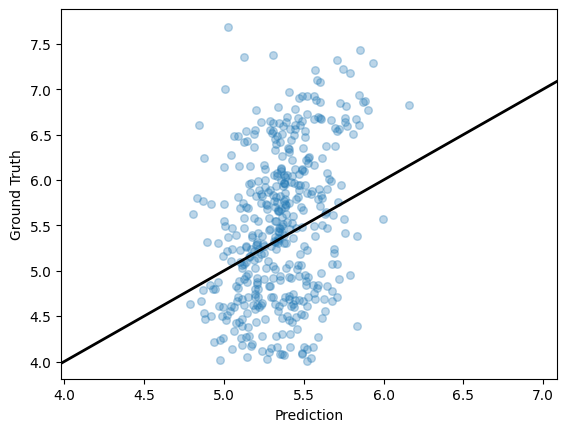

MPRO+PDBBIND2020/SGCNN-20230502-221429-r_d4z77j-SCENARIO4/mpro_test


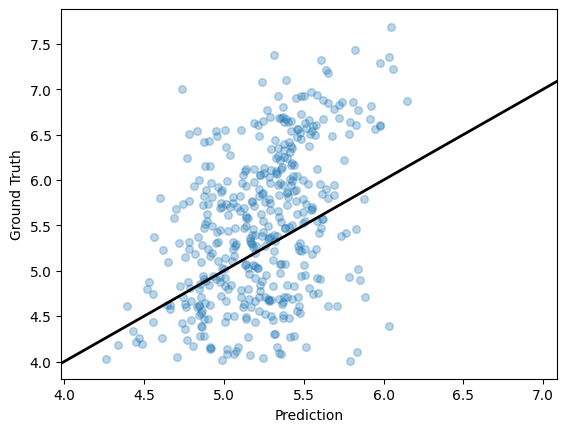

MPRO+PDBBIND2020/EFFICIENTSE3-20230707-011348-k8i84jm7-DEFAULT/mpro_test


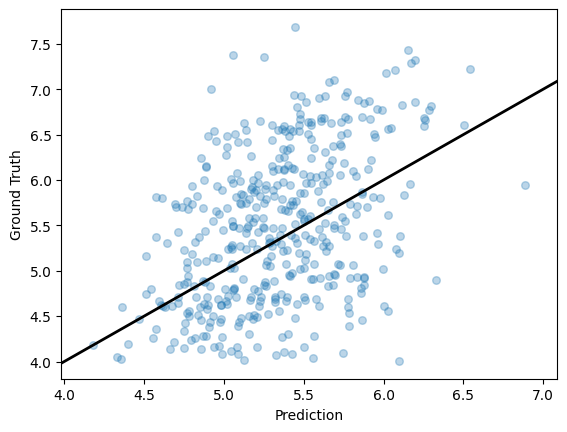

In [7]:
# exp_name = "MPRO/PCN-20230426-200743-4an40ysz-TRAIN80_RANDOM/mpro_test_random"
aggr_method = "average"
s = 30
alpha = 0.3
margin = 0.2

for exp_name in overall_predictions.keys():
    print(exp_name)
    plt.scatter(dt_dict[exp_name][aggr_method], gt_dict[exp_name], s=s, alpha=alpha)

    plt.xlim(min_dt - margin, max_dt + margin)
    plt.ylim(min_gt - margin, max_gt + margin)
    
    x = y = plt.xlim()
    plt.plot(x, y, linewidth=2, color="black")
    
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')
    # plt.title('Correlation Plot')
    plt.show()